# Ch 6. Kernel smoothing methods

In [13]:
# Import dependent packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
import scipy as sp
from scipy import linalg
plt.style.use('seaborn')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklego.linear_model import LowessRegression
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from sklego.linear_model import LowessRegression
import numpy.linalg as la
from sklearn.neighbors import KernelDensity
from scipy.stats import kde


In [29]:
### Function takes two feature transform methods: normalization and MiniMaxScale
def feature_prerpocess(data, form = 'normal'):
    if form == "normal":
        new_data = scale(data)
    elif form == "MinMax":
        new_data = minmax_scale(data)
    return pd.DataFrame(new_data)

## 6.1: One-Dimensional Kernel Smoothers

### 6.1.1: Local regression

Locallly weighted regression solves a separate weighted least squares problem at each target point $x_0$:

- Univarite:
\begin{equation}
min_{\alpha(x_0), \beta(x_0)} = \sum_{i=1}^{N} K_{\lambda}(x_0,x_i)[y_i-\alpha(x_0)- \beta(x_0)x_{i}]^2
\end{equation}

where $K_{\lambda}(x_0,x_i) = D(\frac{|x-x_0|}{\lambda})$

- Multivarite:
\begin{equation}
min_{\beta(x_0)} = \sum_{i=1}^{N} K_{\lambda}(x_0,x_i)[y_i-b(x_i)^T \beta(x_0)x_{i}]^2
\end{equation}

where $b(x_i)^T=(1,x_1,...,x_p)$ and $K_{\lambda}(x_0,x_i) = D(\frac{||x-x_0||}{\lambda})$

There are three main forms of Kernel functions:
1. Epanechnikov quadratic kernel:

\begin{equation}
D(t) = 
  \begin{cases}
   \frac{3}{4}(1-t^2)    & \quad \text{if } |t|\leq 1\\
    0  & \quad \text{otherwise}
  \end{cases}
\end{equation}

2. Tri-cube function:
\begin{equation}
D(t) = 
  \begin{cases}
   (1-|t|^3)^3  & \quad \text{if } |t|\leq 1\\
    0  & \quad \text{otherwise}
  \end{cases}
\end{equation}

3. Gaussian kernel function:
\begin{equation}
D(t) = \Phi(t)
\end{equation}
where $\Phi(t)$ is the Normal cumulative distribution function

In [2]:
# 1. Epanechnikov quadratic kernel
def Epanechnikov(X_distance, **kwargs):
    l = kwargs.get('l', 1.0)
    ans = np.zeros(X_distance.shape)
    X_distance_norm = X_distance / l
    idx = np.where(X_distance_norm <= 1)
    ans[idx] = 0.75 * (1 - X_distance_norm[idx]  ** 2)
    return ans

# 2. Tri-cube function
def Tri_cube(X_distance, **kwargs):
    l = kwargs.get('l', 1.0)
    ans = np.zeros(X_distance.shape)
    X_distance_norm = X_distance / l
    idx = np.where(X_distance_norm <= 1)
    ans[idx] = (1 - np.abs(X_distance_norm[idx]) ** 3) ** 3
    return ans

def Kernel(x0, x, l=1.0, kernel=Epanechnikov):
    # X_distance is the norm of x-x0.
    X_distance = np.sqrt(np.sum(np.power(x - x0[:, np.newaxis], 2), 0))
    return kernel(X_distance, l=l)

In [3]:
def Lowess(x, y, x0, deg=1, kernel=Epanechnikov, l=1):
    # x is d*n matrix, where d-dimension, n-sample size
    # y np.ndarray, n*1 matrix
    # x0 float array, dimension d*n
    if not np.iterable(x0):
        x0 = np.asarray([x0])
    ans = np.zeros(x0.shape[-1])
    # We need one design matrix for fitting:
    B = [np.ones(x.shape[-1])]
    for d in range(1, deg+1):
        B.append(x ** deg)

    B = np.vstack(B).T
    for idx, this_x0 in enumerate(x0.T):
        if not np.iterable(this_x0):
            this_x0 = np.asarray([this_x0])
        W = np.diag(Kernel(this_x0, x, l=l, kernel=kernel))
        BtWB = np.dot(np.dot(B.T, W), B)
        BtW = np.dot(B.T, W)
        # Get the params:
        beta = np.dot(np.dot(la.pinv(BtWB), BtW), y.T)
        B0 = [1]
        for d in range(1, deg+1):
            B0 = np.hstack([B0, this_x0 ** deg])
        B0 = np.vstack(B0).T
        # Estimate the answer based on the parameters:
        ans[idx] += np.dot(B0, beta)
    return ans.T

In [16]:
x = np.random.randn(1, 500)
y = -3.5 * np.sin(x) + 2.5 * np.cos(x) + np.random.randn(500)
y_line = -3.5 * np.sin(x) + 2.5 * np.cos(x)
x0 = np.linspace(-4, 4, 10)

In [5]:
y_predicted_Epanechnikov = Lowess(x, y, x0)

In [6]:
y_predicted_Tri_cube = Lowess(x, y, x0, kernel=Tri_cube)

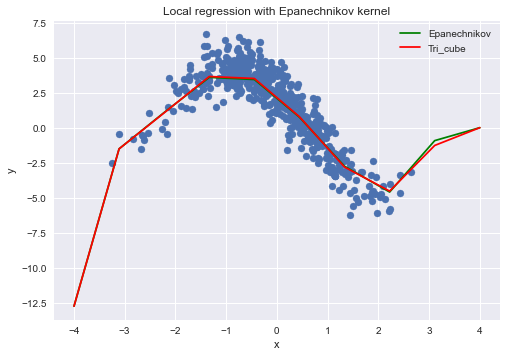

In [7]:
fig, ax = plt.subplots(1)
_ = ax.scatter(x, y)
_ = ax.plot(x0, y_predicted_Epanechnikov, color='green', label="Epanechnikov")
_ = ax.plot(x0, y_predicted_Tri_cube, color='red', label="Tri_cube")
ax.set(xlabel='x', ylabel='y',
       title='Local regression with Epanechnikov kernel');
plt.legend(loc="upper right")

### 6.1.2: Local regression

Locallly weighted regression solves a separate weighted least squares problem at each target point $x_0$:

- Univarite:
\begin{equation}
min_{\alpha(x_0), \beta(x_0)} = \sum_{i=1}^{N} K_{\lambda}(x_0,x_i)[y_i-\alpha(x_0)- \sum_{j=1}^{p}\beta(x_0)x_{i}^j]^2
\end{equation}

where $K_{\lambda}(x_0,x_i) = D(\frac{|x-x_0|}{\lambda})$

- Multivarite:
\begin{equation}
min_{\beta(x_0)} = \sum_{i=1}^{N} K_{\lambda}(x_0,x_i)[y_i-b(x_i)^T \beta(x_0)x_{i}]^2
\end{equation}

where $b(x)$ is a vector of polynomial terms with degree p.For example, with p=2 we get $b(x_i)=(1,x_{1,i},x_{2,i},x_{1,i}^2,x_{2,i}^2,x_{1,i}x_{2,i})$, and $K_{\lambda}(x_0,x_i) = D(\frac{||x-x_0||}{\lambda})$

In [8]:
y_predicted_Epanechnikov = Lowess(x, y, x0, l=0.2, deg=2)
y_predicted_Tri_cube = Lowess(x, y, x0, deg=2, l=0.2, kernel=Tri_cube)

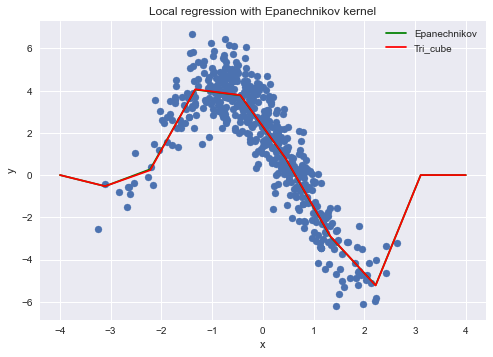

In [9]:
fig, ax = plt.subplots(1)
_ = ax.scatter(x, y)
_ = ax.plot(x0, y_predicted_Epanechnikov, color='green', label="Epanechnikov")
_ = ax.plot(x0, y_predicted_Tri_cube, color='red', label="Tri_cube")
ax.set(xlabel='x', ylabel='y',
       title='Local regression with Epanechnikov kernel');
plt.legend(loc="upper right")

## 6.6: Kernal density estimation and classififcation

### 6.6.1: Kernel density estimation 

The Parzen estimate is of the form:

\begin{equation}
\hat{f_X(x_0)}= \frac{1}{N\lambda} \sum_{i=1}^{N} K_{\lambda}(x_0,x_i)
\end{equation}

where, $x_1,...,x_N$ is a random sample, $\lambda$ is a width parameter

We will use "Seoul Bike" dataset, it can can be downloaded:
* <a href="https://www.kaggle.com/c/seoul-bike-rental-prediction/data">Seoul Bike Rental Prediction
    
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information. The target variable is a bike count required at each hour.

In [10]:
#Download data 
Seoul_bike = pd.read_csv('SeoulBikeData.csv', sep=',', encoding= 'unicode_escape')
Seoul_bike

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [11]:
# we choose temperature variable
X_var = Seoul_bike.iloc[:100, 3]
X_var

0    -5.2
1    -5.5
2    -6.0
3    -6.2
4    -6.0
     ... 
95   -5.8
96   -6.1
97   -6.5
98   -6.8
99   -6.9
Name: Temperature(°C), Length: 100, dtype: float64

C:\Users\NysanAskar\anaconda3\lib\site-packages\seaborn\distributions.py:1668: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\NysanAskar\anaconda3\lib\site-packages\seaborn\distributions.py:1668: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\NysanAskar\anaconda3\lib\site-packages\seaborn\distributions.py:1668: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Temperature(°C)', ylabel='Density'>

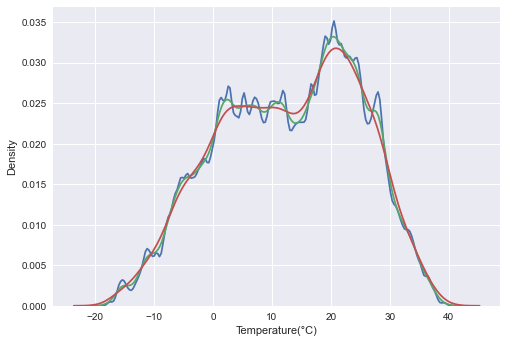

In [12]:
sns.kdeplot(data=Seoul_bike, x="Temperature(°C)", bw_adjust=0.2, kernel="gau")
sns.kdeplot(data=Seoul_bike, x="Temperature(°C)", bw_adjust=0.5, kernel="trw")
sns.kdeplot(data=Seoul_bike, x="Temperature(°C)", bw_adjust=1, kernel="epa")

### 6.6.2: Kernel density classifiction 

We can use nonparametric density estimates for the classification problem using Bayes' theorem:

\begin{equation}
Pr(G=j|X=x_0)=\frac{\hat{f_j(x_0)\hat{\pi_j}}}{\sum_{k=1}^{J}\hat{f_k(x_0)}\hat{\pi_k}}
\end{equation}

\begin{equation}
\hat{\pi_j} = \frac{1}{n}\sum_{i=1}^{n}I(Y_i=y)
\end{equation}

\begin{equation}
\hat{f_k(x_0)} = \frac{1}{n_y\lambda}\sum_{i=1}^{n}I(Y_i=y)K_{\lambda}(x_0,x_i)
\end{equation}

We will use "Audit" dataset, it can be downloaded:
* <a href="https://archive.ics.uci.edu/ml/datasets/Audit+Data#">Audit Dataset
    
The dataset contains 777 different firms that are collected from six distinct sectors. The information about the sectors and the counts of firms are listed respectively as Irrigation (114), Public Health (77), Buildings and Roads (82), Forest (70), Corporate (47), Animal Husbandry (95), Communication (1), Electrical (4), Land (5), Science and Technology (3), Tourism (1), Fisheries (41), Industries (37), Agriculture (200). Many risk factors are examined from various areas like past records of audit office, audit-paras, environmental conditions reports, firm reputation summary, on-going issues report, profit-value records, loss-value records, follow-up reports etc.

In [20]:
#Download data 
Audit = pd.read_csv('audit_risk.csv', sep=',', encoding= 'unicode_escape')
Audit.describe()

,Sector_score,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,...,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.0,776.000000,776.000000
mean,20.184536,2.450194,0.351289,1.351029,10.799988,0.313144,6.334008,13.218481,5.067655,0.223711,...,0.519072,0.104381,0.216753,0.053608,2.702577,17.680612,0.572680,0.5,7.168158,0.393041
std,24.319017,5.678870,0.174055,3.440447,50.083624,0.169804,30.072845,51.312829,0.264449,0.080352,...,0.290312,0.531031,0.067987,0.305835,0.858923,54.740244,0.444581,0.0,38.667494,0.488741
min,1.850000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.000000,1.400000,0.400000,0.5,0.280000,0.000000
25%,2.370000,0.210000,0.200000,0.042000,0.000000,0.200000,0.000000,0.537500,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.000000,1.583500,0.400000,0.5,0.316700,0.000000
50%,3.890000,0.875000,0.200000,0.175000,0.405000,0.200000,0.081000,1.370000,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.400000,2.214000,0.400000,0.5,0.555600,0.000000
75%,55.570000,2.480000,0.600000,1.488000,4.160000,0.400000,1.840500,7.707500,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,3.250000,10.663500,0.400000,0.5,3.249900,1.000000
max,59.850000,85.000000,0.600000,51.000000,1264.630000,0.600000,758.778000,1268.910000,9.000000,0.600000,...,2.400000,9.000000,0.600000,5.400000,5.200000,801.262000,5.800000,0.5,961.514400,1.000000


In [30]:
#Feature matrix
X_matrix = Audit[Audit.columns[~Audit.columns.isin(["LOCATION_ID", 'Risk'])]]
X_matrix = X_matrix.fillna(method ='pad') 
X_matrix = feature_prerpocess(X_matrix, form = 'normal')

In [43]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_matrix, Y_var, test_size=0.30)

In [22]:
# Response indicator matrix
Y = Audit[["Risk"]]
Y_var = Audit[["Risk"]]
Y = Y.astype('str') 
Y_matrix = pd.get_dummies(Y)

In [74]:
# Classification with Gaussian Kernel density function
fraudulent_firm = pd.concat([X_train,y_train],axis=1)[pd.concat([X_train,y_train],axis=1)["Risk"]==1]
Not_fraudulent_firm = pd.concat([X_train,y_train],axis=1)[pd.concat([X_train,y_train],axis=1)["Risk"]==0]
score = []
kde_model = KernelDensity(kernel='gaussian', bandwidth=0.2)
for i in [fraudulent_firm, Not_fraudulent_firm]:
    kde_model.fit(i.drop('Risk', axis=1))
    score.append(np.exp(kde_model.score_samples(X_test)))
    
Y_fitted = pd.DataFrame(np.where(score[0]>score[1], 1,0))
# Calculate error rate
Error_rate = np.sum(np.abs(Y_fitted.iloc[:,0]-y_test.iloc[:,0]))/len(Y_fitted)
Error_rate

0.17167381974248927

### 6.6.3: The naive Bayes classifier with Kernel density function 

When the dimension $p$ of the feature space is high, density estimation becomes a tedious task. The naive Bayes model assumes that given a class $G=j$, the features $X_k$ are independent: 

\begin{equation} 
Pr(X=x_0|G=j)=\prod_{k=1}^{p} Pr(X_k=x_{0k}|G=j)
\end{equation}

Then we can derive the logit-transform (using $J$ class as the base):

\begin{equation} 
log \frac{Pr(G=l|X=x_0)}{Pr(G=J|X=x_0)}=log\frac{f_l(x_0)\pi_l}{f_J(x_0)\pi_J}=log\frac{\pi_l}{\pi_J}+\sum_{k=1}^{p}log\frac{f_lk(x_k)}{f_Jk(x_k)}=log\frac{\pi_l}{\pi_J}+\sum_{k=1}^{p}(logf_lk(x_k)-logf_Jk(x_k))
\end{equation}
 where $f_l(x_0)=\prod_{k=1}^{p} Pr(X_k=x_{0k}|G=l)$

In [229]:
# Classification with Naive Bayes Epanechnikov Kernel function
fraudulent_firm = pd.concat([X_train,y_train],axis=1)[pd.concat([X_train,y_train],axis=1)["Risk"]==1]
Not_fraudulent_firm = pd.concat([X_train,y_train],axis=1)[pd.concat([X_train,y_train],axis=1)["Risk"]==0]
score_fraudulent_firm = [] 
score_Not_fraudulent_firm = [] 
kde_model = KernelDensity(kernel='epanechnikov', bandwidth=0.5)

#1. scores for fraudulent_firm: 
for i in range(0,25):
    kde_model.fit(fraudulent_firm[[i]])
    score_fraudulent_firm.append(kde_model.score_samples(X_test[[i]]))
    
#2. scores for non fraudulent_firm: 
for i in range(0,25):
    kde_model.fit(Not_fraudulent_firm[[i]])
    score_Not_fraudulent_firm.append(kde_model.score_samples(X_test[[i]]))

score_difference = []
for i in range(0,25):
    score_difference.append(score_fraudulent_firm[i]-score_Not_fraudulent_firm[i])

score_difference_test = np.sum(np.array(list(map(list, zip(*score_difference)))),axis = 1) + np.log((len(y_test[y_test['Risk'] ==1])/len(y_test))/(1-len(y_test[y_test['Risk'] ==1])/len(y_test)))
# Fitted values
Y_fitted = pd.DataFrame(np.where(score_difference_test>0, 1, 0))
# Calculate error rate
Error_rate = np.sum(np.abs(Y_fitted.iloc[:,0]-y_test.iloc[:,0]))/len(Y_fitted)
Error_rate

<ipython-input-229-c5aa34802e31>:20: RuntimeWarning: invalid value encountered in subtract
  score_difference.append(score_fraudulent_firm[i]-score_Not_fraudulent_firm[i])


0.1630901287553648